<a href="https://colab.research.google.com/github/ateebkhan96/Brain-Tumor-Detection-using-YOLO11/blob/main/Brain_Tumor_Detection_using_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import os
import shutil
import yaml
import random
from pathlib import Path
import glob

import cv2
from PIL import Image
import skimage.io as io
from skimage import measure
from skimage.measure import label, regionprops
from scipy import ndimage


try:
    from ultralytics import YOLO
except ImportError:
    !pip install -q ultralytics
    from ultralytics import YOLO

try:
    from ultralytics import YOLO
except ImportError:
    !pip install -q albumentations
    from ultralytics import YOLO

import kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

# Downloading the Dataset

In [2]:
mateuszbuda_lgg_mri_segmentation_path = kagglehub.dataset_download('mateuszbuda/lgg-mri-segmentation')

print('Data source import complete.')
print(f'Data is stored at path: {mateuszbuda_lgg_mri_segmentation_path}')

Data source import complete.
Data is stored at path: /kaggle/input/lgg-mri-segmentation


# Exploratory and Visualizing theData

In [3]:
# Defining paths
dataset_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
metadata_path = os.path.join(dataset_path,"data.csv")

In [4]:
# Peeking into metadata file
if os.path.exists(metadata_path):
    metadata = pd.read_csv(metadata_path)
    print('Metadata Shape: ', metadata.shape)
    print('\nMetadata Columns: ', metadata.columns.tolist())
    print('\nMetadata Sample:')
    print(metadata.head())
else:
    print("Metadata File Not Found")

Metadata Shape:  (110, 18)

Metadata Columns:  ['Patient', 'RNASeqCluster', 'MethylationCluster', 'miRNACluster', 'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster', 'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site', 'laterality', 'tumor_location', 'gender', 'age_at_initial_pathologic', 'race', 'ethnicity', 'death01']

Metadata Sample:
        Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0            

In [46]:
#Total Number of Patients
patients = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path,d))]
print(f"\nTotal Number of Patients: {len(patients)}\n")

# Total Number Images and Masks
total_images = 0
total_masks = 0
i=0
print('Displaying 5 patients sample\n')
for patient in patients:  # just check first 5 patients for quick exploration
    patient_path = os.path.join(dataset_path, patient)
    files = os.listdir(patient_path)
    images = [f for f in files if not f.endswith('_mask.tif')]
    masks = [f for f in files if f.endswith('_mask.tif')]
    total_images += len(images)
    total_masks += len(masks)
    while(i<5):
      print(f"Patient {patient}: {len(images)} images, {len(masks)} masks")
      i+=1

print(f"\nChecked total {len(patients)} patients with total of {total_images} images and {total_masks} masks")


Total Number of Patients: 110

Displaying 5 patients sample

Patient TCGA_DU_7010_19860307: 58 images, 58 masks
Patient TCGA_DU_7010_19860307: 58 images, 58 masks
Patient TCGA_DU_7010_19860307: 58 images, 58 masks
Patient TCGA_DU_7010_19860307: 58 images, 58 masks
Patient TCGA_DU_7010_19860307: 58 images, 58 masks

Checked total 110 patients with total of 3929 images and 3929 masks


Creating dataset overview visualizations...


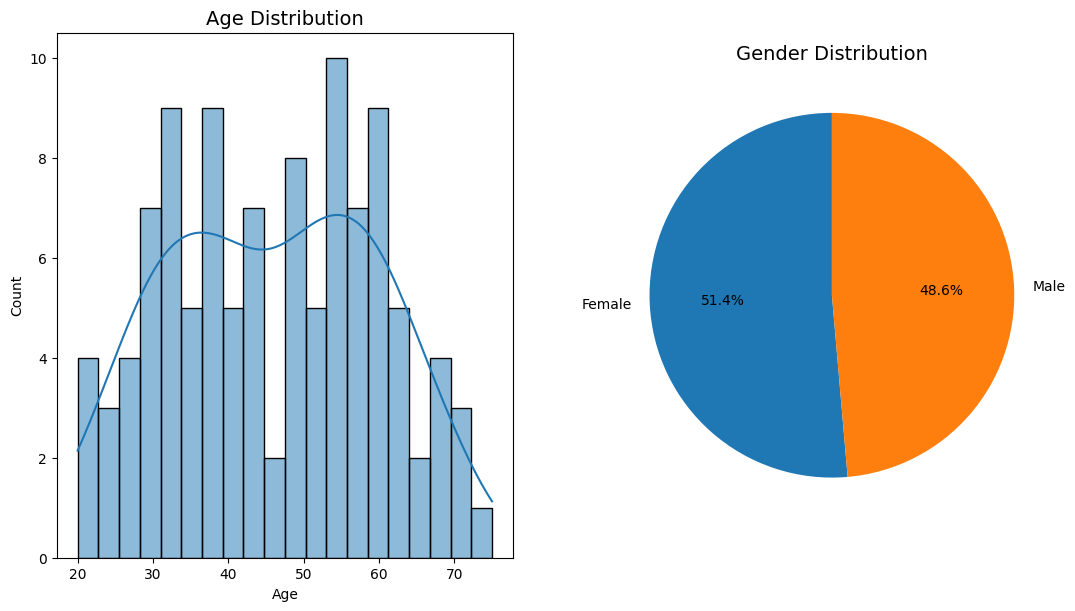

In [6]:
def create_dataset_visualizations(metadata):
    fig = plt.figure(figsize=(20, 15))

    # Age distribution
    plt.subplot(2, 3, 1)
    sns.histplot(metadata['age_at_initial_pathologic'].dropna(), bins=20, kde=True)
    plt.title('Age Distribution', fontsize=14)
    plt.xlabel('Age')

    # Gender distribution
    plt.subplot(2, 3, 2)

    # Map 1 to 'Female' and 2 to 'Male'
    gender_labels = {1: 'Female', 2: 'Male'}
    metadata['gender_label'] = metadata['gender'].map(gender_labels)

    # Count gender occurrences
    gender_counts = metadata['gender_label'].value_counts()

    # Plot pie chart
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Gender Distribution', fontsize=14)

print("Creating dataset overview visualizations...")
create_dataset_visualizations(metadata)

Image 1 (Age Distribution): This histogram displays the age distribution of patients diagnosed. It indicates the frequency of initial pathologic diagnoses across different age groups. Given that LGGs are more common in younger adults compared to high-grade gliomas, the distribution likely shows a central tendency in a younger age range, possibly between 30 and 50 years old, with fewer cases in older populations. This visualization helps understand the typical age range affected by LGGs in this dataset.

Image 2 (Gender Distribution): This pie chart illustrates the gender distribution within the Low-Grade Glioma (LGG) patient dataset. The percentages indicate a slight predominance of females (51.4%) over males (48.6%). While some studies suggest a slightly higher incidence of gliomas overall in males, this specific LGG dataset shows a near balance, with a marginal lean towards females. This information is relevant as some research indicates potential gender-specific molecular differences and outcomes in glioma patients.

Visualizing sample MRI images...


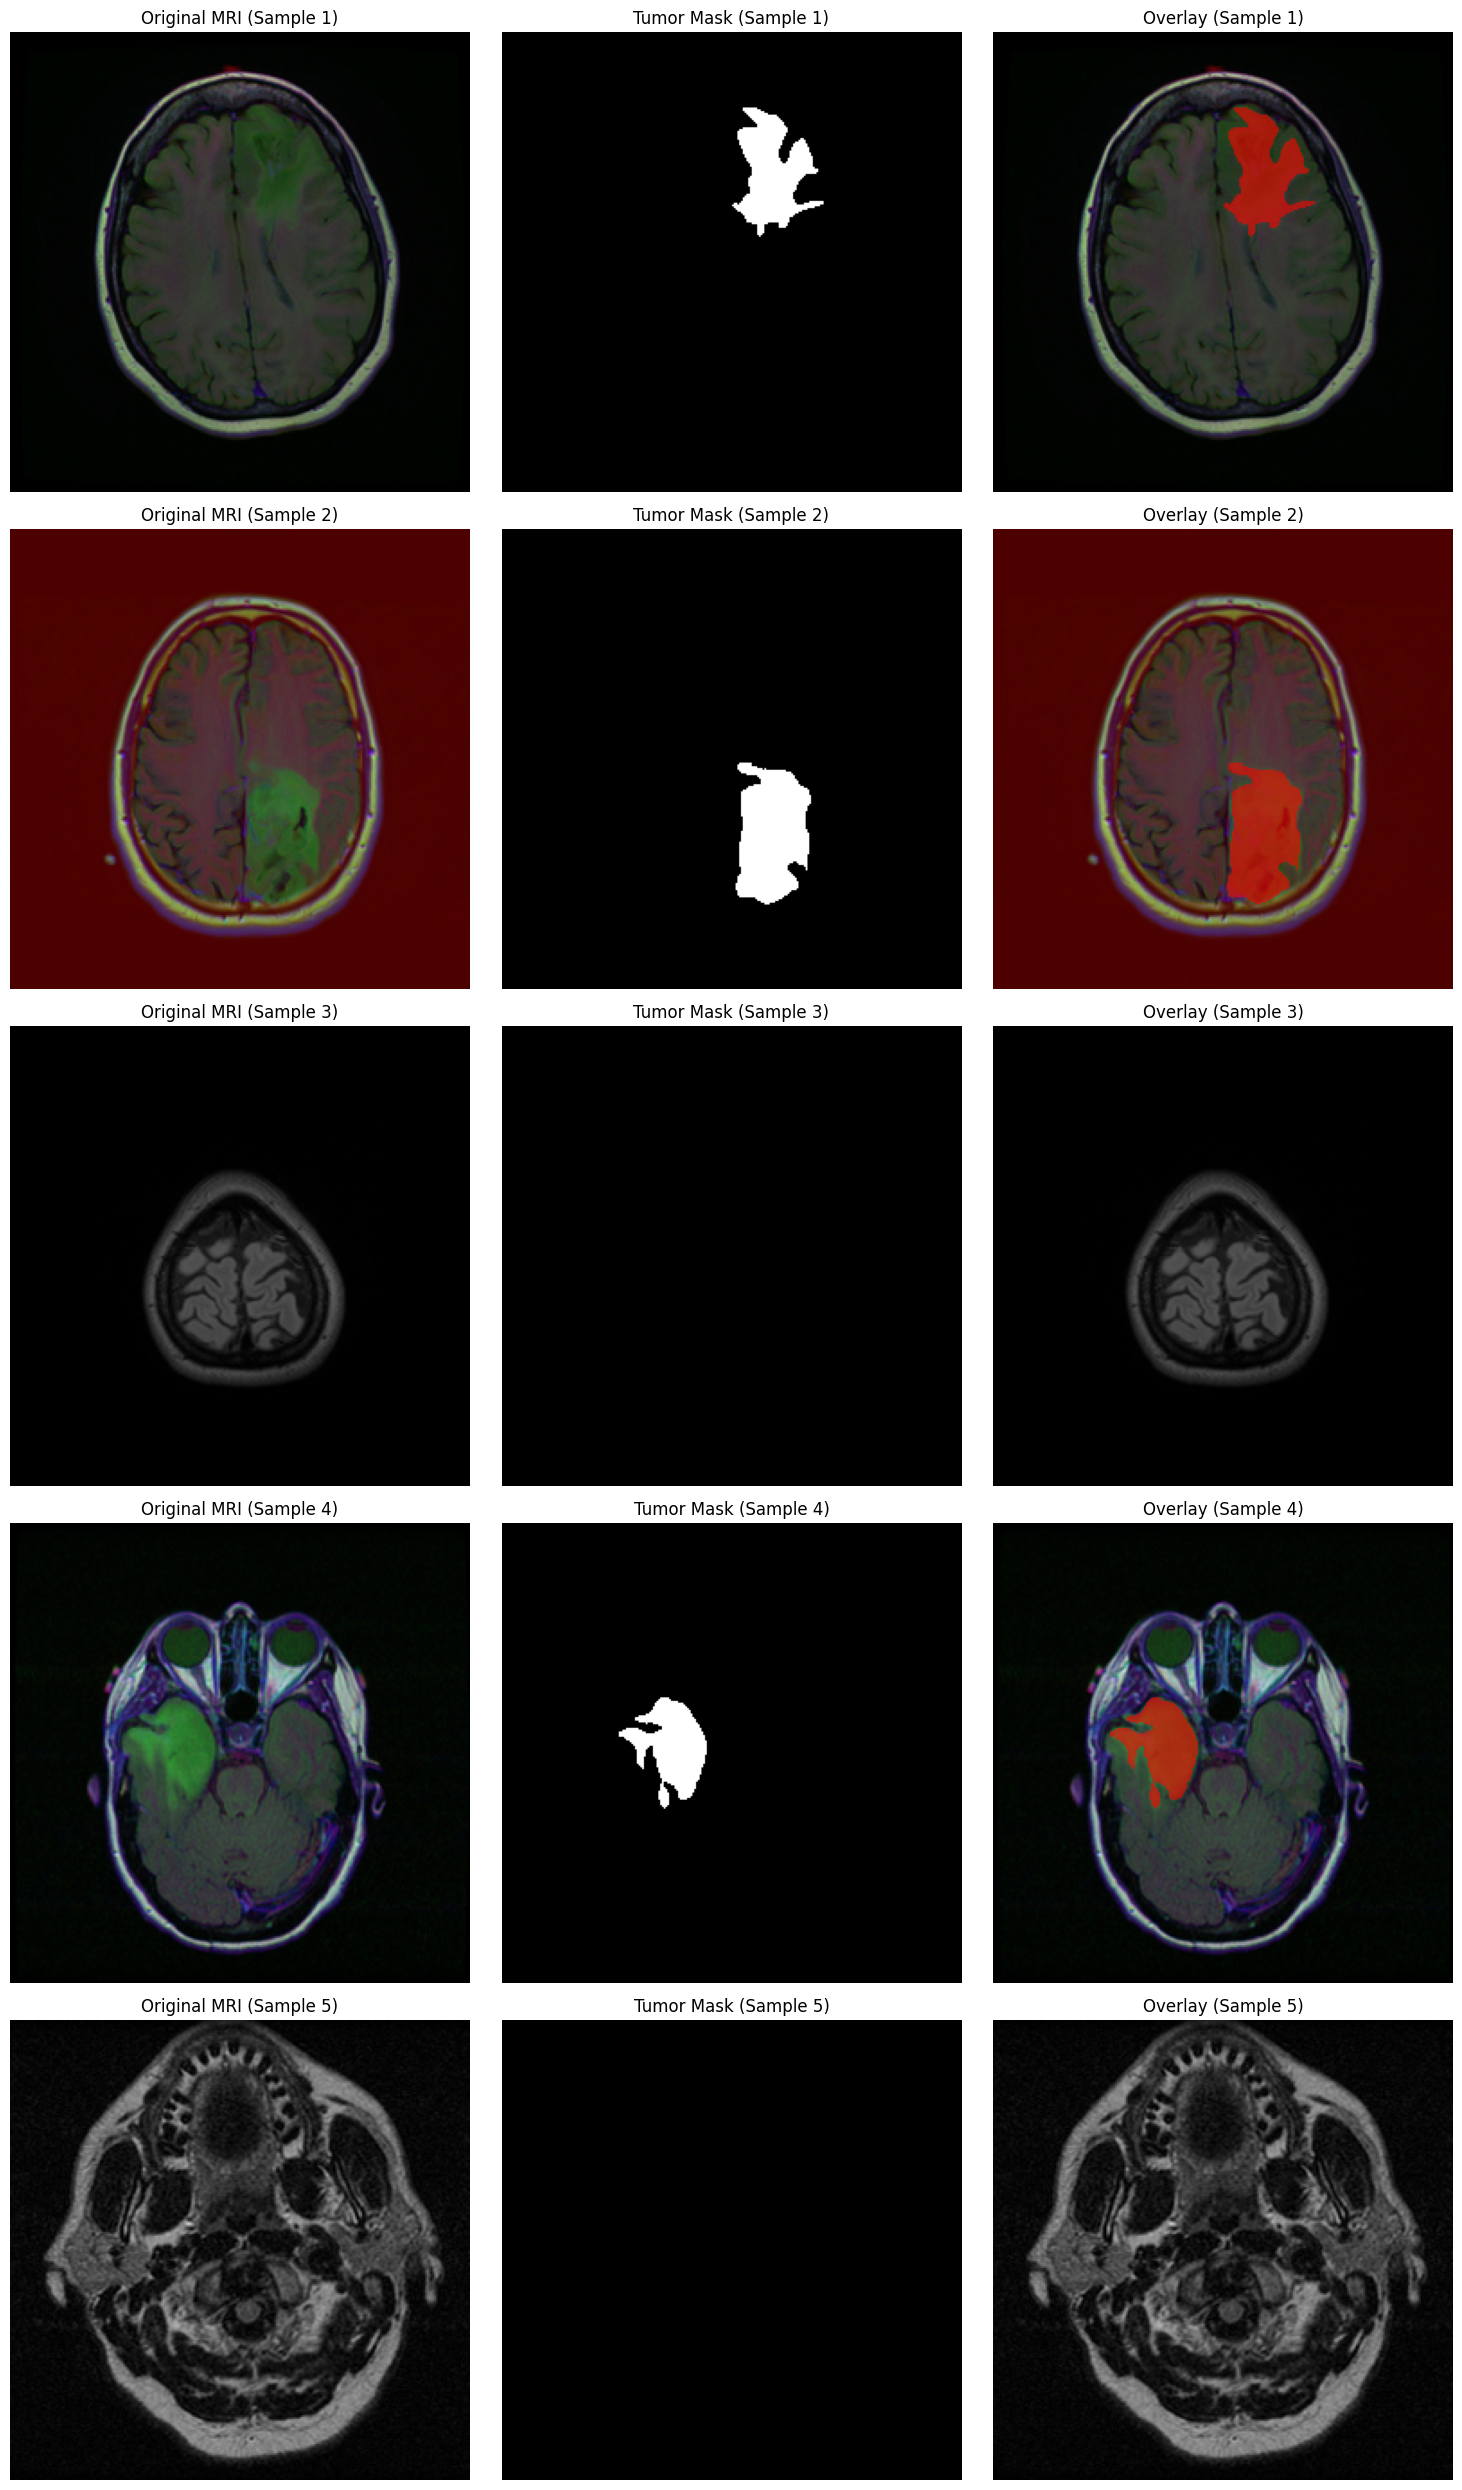

In [44]:
def visualize_sample_images(dataset_path, num_samples=5):
    """Visualize sample MRI images with their masks."""
    # Find image-mask pairs
    image_mask_pairs = []

    for root, _, files in os.walk(dataset_path):
        masks = [f for f in files if f.endswith('_mask.tif')]
        for mask in masks:
            image = mask.replace('_mask.tif', '.tif')
            if image in files:
                image_path = os.path.join(root, image)
                mask_path = os.path.join(root, mask)
                image_mask_pairs.append((image_path, mask_path))

    # Randomly select samples
    if len(image_mask_pairs) > num_samples:
        selected_pairs = random.sample(image_mask_pairs, num_samples)
    else:
        selected_pairs = image_mask_pairs

    # Create visualizations
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    if num_samples == 1:
        axes = [axes]  # Make it indexable for the loop

    for i, (image_path, mask_path) in enumerate(selected_pairs):
        # Load image and mask
        image = io.imread(image_path)
        mask = io.imread(mask_path)

        # Original image
        axes[i][0].imshow(image, cmap='gray')
        axes[i][0].set_title(f'Original MRI (Sample {i+1})')
        axes[i][0].axis('off')

        # Mask
        axes[i][1].imshow(mask, cmap='gray')
        axes[i][1].set_title(f'Tumor Mask (Sample {i+1})')
        axes[i][1].axis('off')

        # Overlay
        axes[i][2].imshow(image, cmap='gray')
        # Create a custom colormap for the overlay
        tumor_cmap = LinearSegmentedColormap.from_list('tumor_cmap', [(1, 0, 0, 0), (1, 0, 0, 1)])
        axes[i][2].imshow(mask, cmap=tumor_cmap, alpha=0.6)
        axes[i][2].set_title(f'Overlay (Sample {i+1})')
        axes[i][2].axis('off')

    plt.tight_layout()

    plt.show()

print("Visualizing sample MRI images...")
visualize_sample_images(dataset_path, num_samples=5)

Assessing segmentation quality...


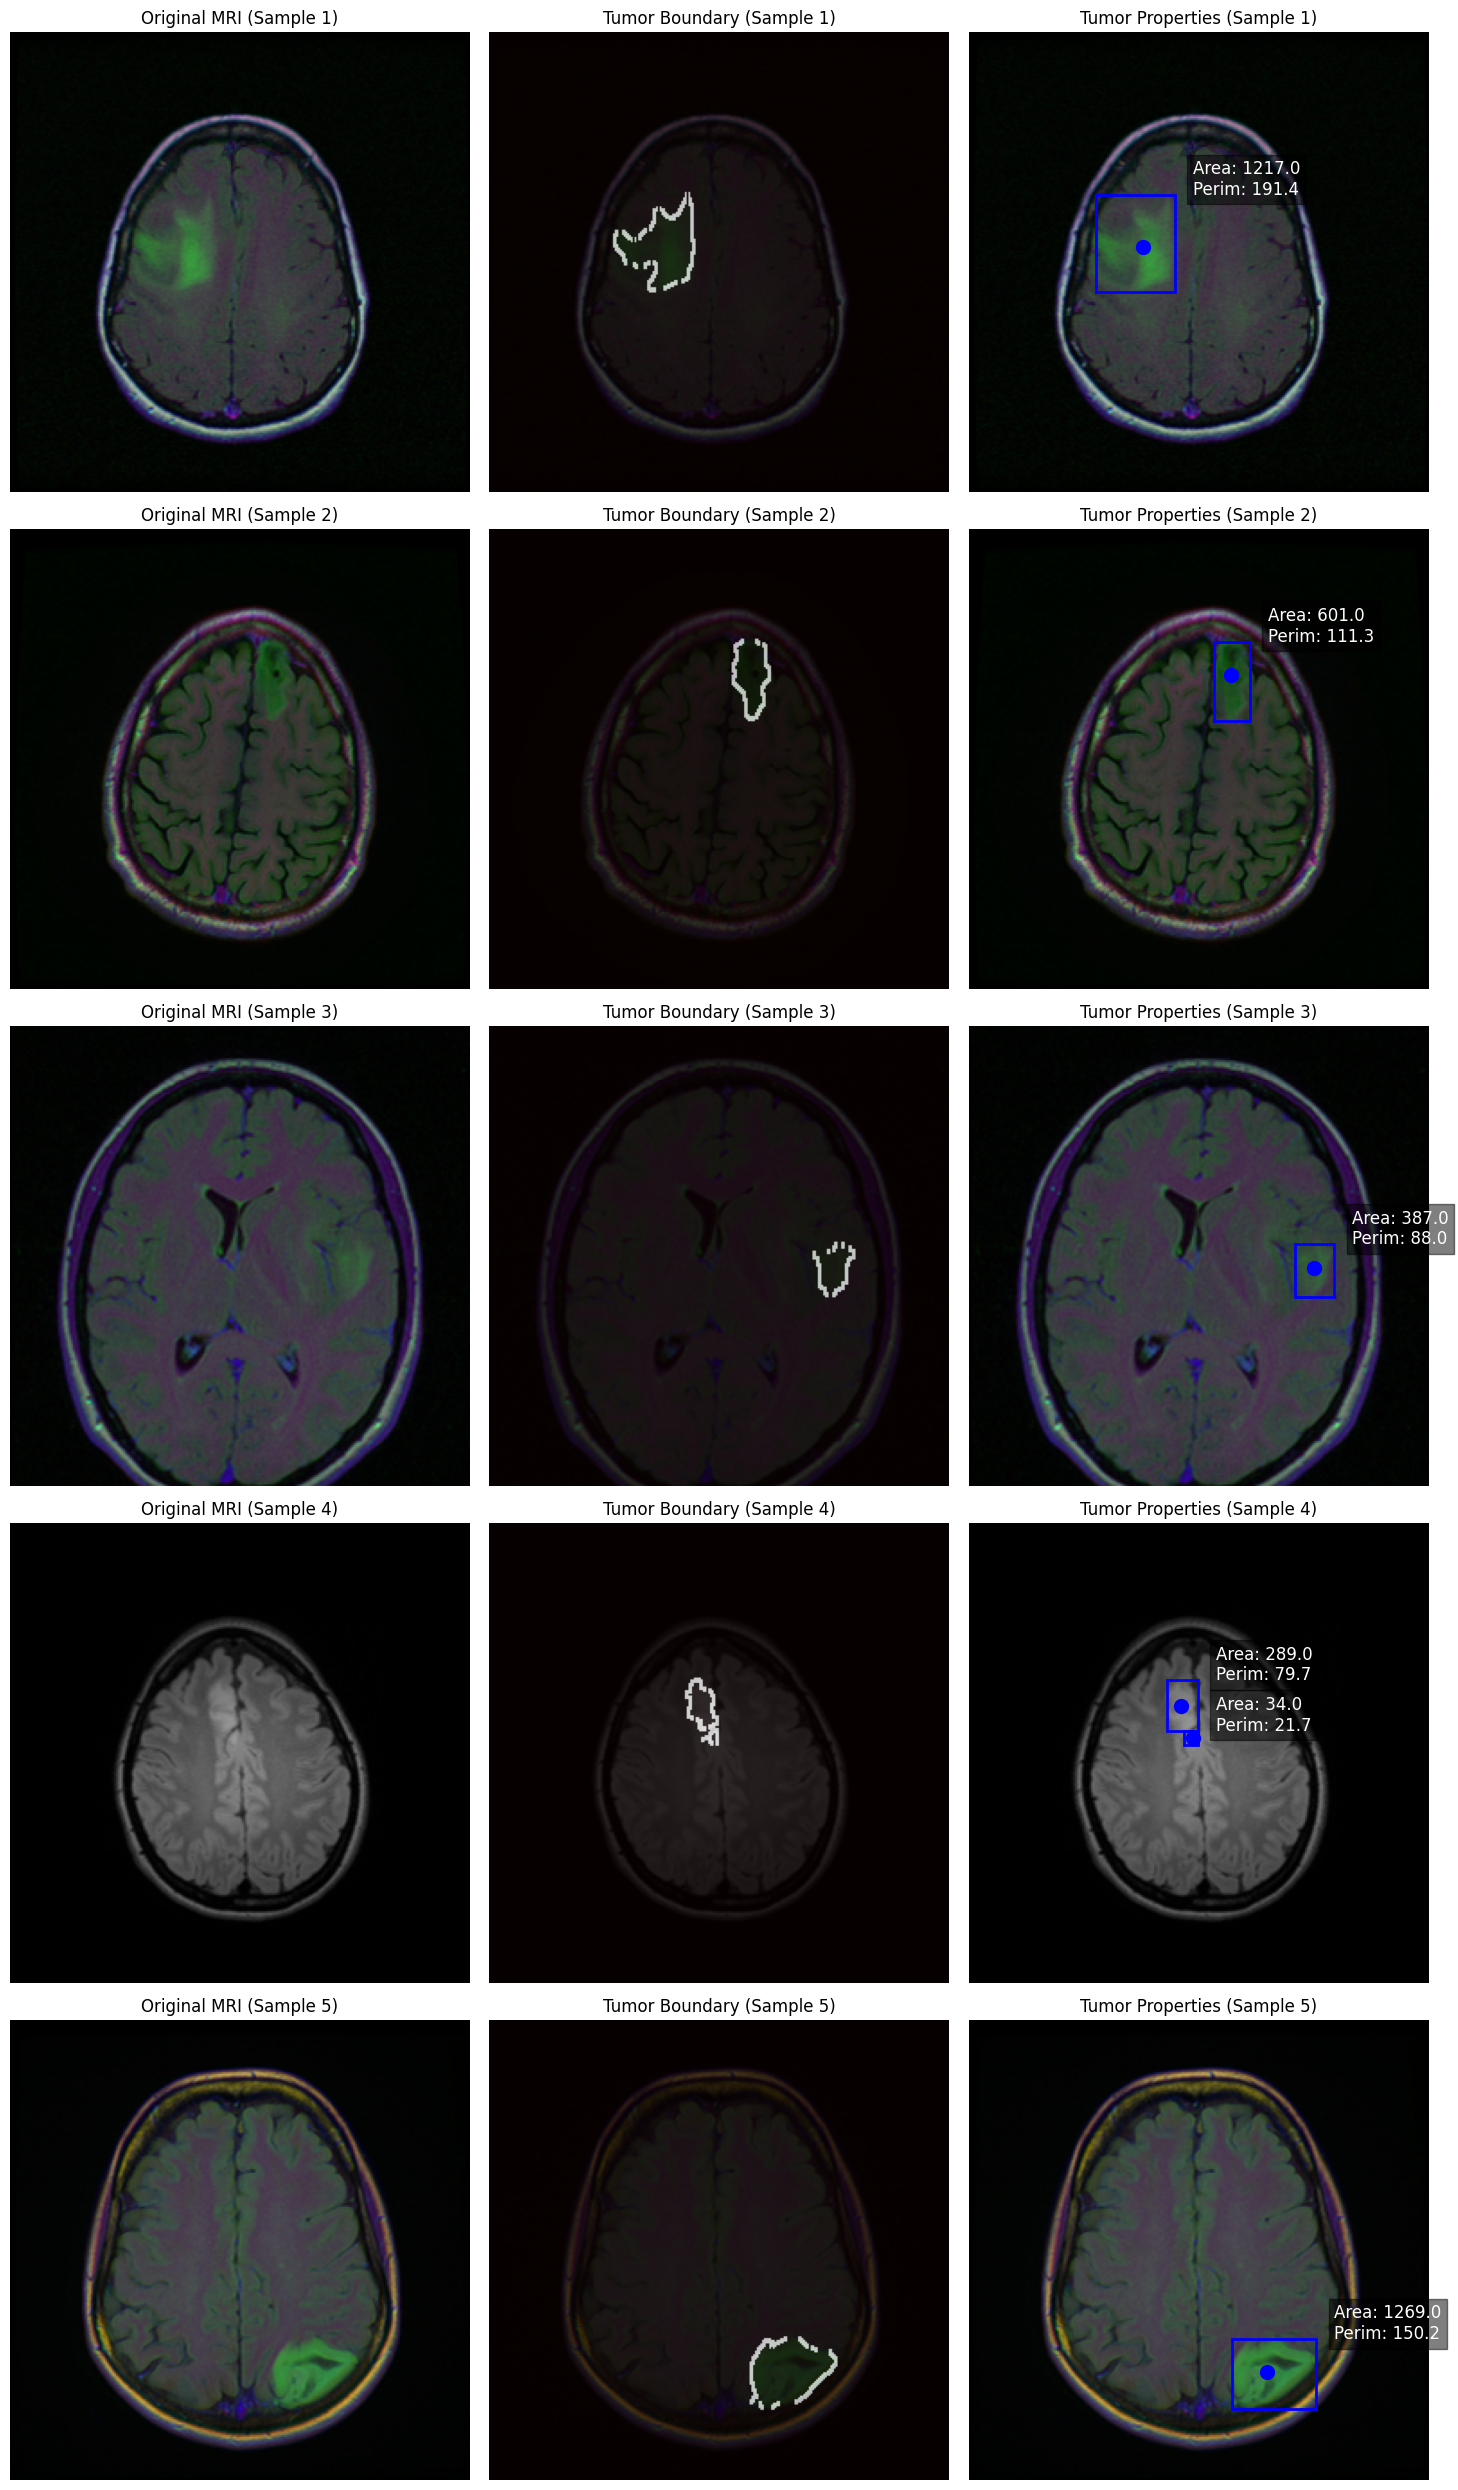

In [8]:
def assess_segmentation_quality(dataset_path, num_samples=5):
    """Assess the quality of tumor segmentations, visualizing only non-empty masks."""
    # Find image-mask pairs
    image_mask_pairs = []

    for root, _, files in os.walk(dataset_path):
        masks = [f for f in files if f.endswith('_mask.tif')]
        for mask in masks:
            image = mask.replace('_mask.tif', '.tif')
            if image in files:
                image_path = os.path.join(root, image)
                mask_path = os.path.join(root, mask)
                image_mask_pairs.append((image_path, mask_path))

    # Filter out empty masks
    valid_pairs = [(img_path, msk_path, io.imread(msk_path))
                   for img_path, msk_path in image_mask_pairs if np.any(io.imread(msk_path) > 0)]

    if not valid_pairs:
        print("No valid image-mask pairs found with tumor segmentations.")
        return

    # Randomly select samples from valid pairs
    if len(valid_pairs) > num_samples:
        selected_pairs_with_masks = random.sample(valid_pairs, min(num_samples, len(valid_pairs)))
    else:
        selected_pairs_with_masks = valid_pairs

    num_plots = len(selected_pairs_with_masks)
    if num_plots == 0:
        print("No non-empty masks found for visualization.")
        return

    # Create visualizations only if there are non-empty masks
    fig, axes = plt.subplots(num_plots, 3, figsize=(15, 5 * num_plots))

    if num_plots == 1:
        axes = [axes]  # Make it indexable for the loop

    for i, (image_path, mask_path, mask) in enumerate(selected_pairs_with_masks):
        # Load image (mask is already loaded)
        image = io.imread(image_path)

        # Original image
        axes[i][0].imshow(image, cmap='gray')
        axes[i][0].set_title(f'Original MRI (Sample {i+1})')
        axes[i][0].axis('off')

        # Edge detection on mask
        edges = ndimage.sobel(mask > 0)

        # Original with tumor boundary
        axes[i][1].imshow(image, cmap='gray')
        axes[i][1].imshow(edges, cmap='hot', alpha=0.7)
        axes[i][1].set_title(f'Tumor Boundary (Sample {i+1})')
        axes[i][1].axis('off')

        # Show tumor properties
        labeled_mask = label(mask > 0)
        regions = regionprops(labeled_mask)

        axes[i][2].imshow(image, cmap='gray')

        for props in regions:
            y, x = props.centroid
            axes[i][2].plot(x, y, 'bo', markersize=10)

            # Get bounding box
            minr, minc, maxr, maxc = props.bbox
            bounding_box = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                        fill=False, edgecolor='blue', linewidth=2)
            axes[i][2].add_patch(bounding_box)

            # Add text with properties
            area = props.area
            perimeter = props.perimeter
            text = f"Area: {area}\nPerim: {perimeter:.1f}"
            axes[i][2].text(maxc + 10, minr, text, color='white', fontsize=12,
                            bbox=dict(facecolor='black', alpha=0.5))

        axes[i][2].set_title(f'Tumor Properties (Sample {i+1})')
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'dataset_path' is defined somewhere in your script
print("Assessing segmentation quality...")
assess_segmentation_quality(dataset_path, num_samples=5)

# Yolo Conversion and Train, Val, Test Split

### Yolo Conversion helper functions

In [9]:
#Path Setup
original_dataset = Path("/kaggle/input/lgg-mri-segmentation/kaggle_3m")
# Output YOLO dataset path
yolo_dataset = Path("dataset_yolo")
(yolo_dataset / "images/train").mkdir(parents=True, exist_ok=True)
(yolo_dataset / "images/val").mkdir(parents=True, exist_ok=True)
(yolo_dataset / "labels/train").mkdir(parents=True, exist_ok=True)
(yolo_dataset / "labels/val").mkdir(parents=True, exist_ok=True)

In [10]:
# Bounding Box and YOLO Format Conversion

def mask_to_bbox(mask):
    mask_np = np.array(mask)
    if np.sum(mask_np) == 0:
        return None  # No tumor
    y_indices, x_indices = np.where(mask_np > 0)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    return x_min, y_min, x_max, y_max


def convert_to_yolo_format(xmin, ymin, xmax, ymax, width, height):
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
    return [0, x_center, y_center, w, h]  # class 0: tumor

In [11]:
def process_patients(patients, split):
    for patient_path in patients:
        for file in patient_path.glob("*_mask.tif"):
            mask = Image.open(file)
            bbox = mask_to_bbox(mask)
            if bbox is None:
                continue  # Skip empty masks

            # Image path
            image_file = file.with_name(file.name.replace("_mask.tif", ".tif"))
            if not image_file.exists():
                continue

            # Convert image to .jpg
            image = Image.open(image_file).convert("RGB")
            width, height = image.size

            # Use base image filename without extension (like in process_and_save)
            filename = image_file.stem  # e.g., "image_001"
            image_output = yolo_dataset / f"images/{split}" / f"{filename}.jpg"
            image.save(image_output, format="JPEG")

            # Create label file
            bbox_yolo = convert_to_yolo_format(*bbox, width, height)
            label_output = yolo_dataset / f"labels/{split}" / f"{filename}.txt"
            with open(label_output, "w") as f:
                f.write(" ".join([str(round(x, 6)) for x in bbox_yolo]))

    print(f"[✓] {split.capitalize()} set processed")

### Train, Val and Test Split

In [12]:
# Split Dataset into Train and Validation

patients = list(original_dataset.glob("*"))
random.shuffle(patients)

split_idx = int(len(patients) * 0.8)
train_patients = patients[:split_idx]
val_patients = patients[split_idx:]

process_patients(train_patients, "train")
process_patients(val_patients, "val")

[✓] Train set processed
[✓] Val set processed


In [13]:
# Move a Few Images to Test Set

def move_to_test(from_dir, label_dir, percent):
    images = list(from_dir.glob("*.jpg"))
    n = max(1, int(len(images) * percent / 100))
    selected = random.sample(images, n)
    test_image_dir = yolo_dataset / "images/test"
    test_label_dir = yolo_dataset / "labels/test"
    test_image_dir.mkdir(parents=True, exist_ok=True)
    test_label_dir.mkdir(parents=True, exist_ok=True)
    for img in selected:
        shutil.move(str(img), test_image_dir / img.name)
        lbl = label_dir / (img.stem + ".txt")
        if lbl.exists():
            shutil.move(str(lbl), test_label_dir / lbl.name)
    print(f"[✓] Moved {n} files from {from_dir.name} to test set.")

In [14]:
# Perform Test Set Split
# Moving selected images from train/val to test
move_to_test(yolo_dataset / "images/train", yolo_dataset / "labels/train", 5)
move_to_test(yolo_dataset / "images/val", yolo_dataset / "labels/val", 3)
print("[✓] Test set created")

[✓] Moved 54 files from train to test set.
[✓] Moved 8 files from val to test set.
[✓] Test set created


# Exploring Converted Data

In [15]:
# Count Images and Labels in Each Split

def count_files(split):
    images = list((yolo_dataset / f"images/{split}").glob("*.jpg"))
    labels = list((yolo_dataset / f"labels/{split}").glob("*.txt"))
    print(f"{split.upper()}: {len(images)} images, {len(labels)} labels")

for split in ["train", "val", "test"]:
    count_files(split)

TRAIN: 1032 images, 1032 labels
VAL: 279 images, 279 labels
TEST: 62 images, 62 labels


In [16]:
# Check if all images have a corresponding label file
def check_missing_labels(split):
    missing = []
    image_dir = yolo_dataset / f"images/{split}"
    label_dir = yolo_dataset / f"labels/{split}"
    for image in image_dir.glob("*.jpg"):
        label = label_dir / (image.stem + ".txt")
        if not label.exists():
            missing.append(image.name)
    print(f"{split.upper()} - Missing labels: {len(missing)}")
    if missing:
        print("Examples:", missing[:5])

for split in ["train", "val", "test"]:
    check_missing_labels(split)

TRAIN - Missing labels: 0
VAL - Missing labels: 0
TEST - Missing labels: 0


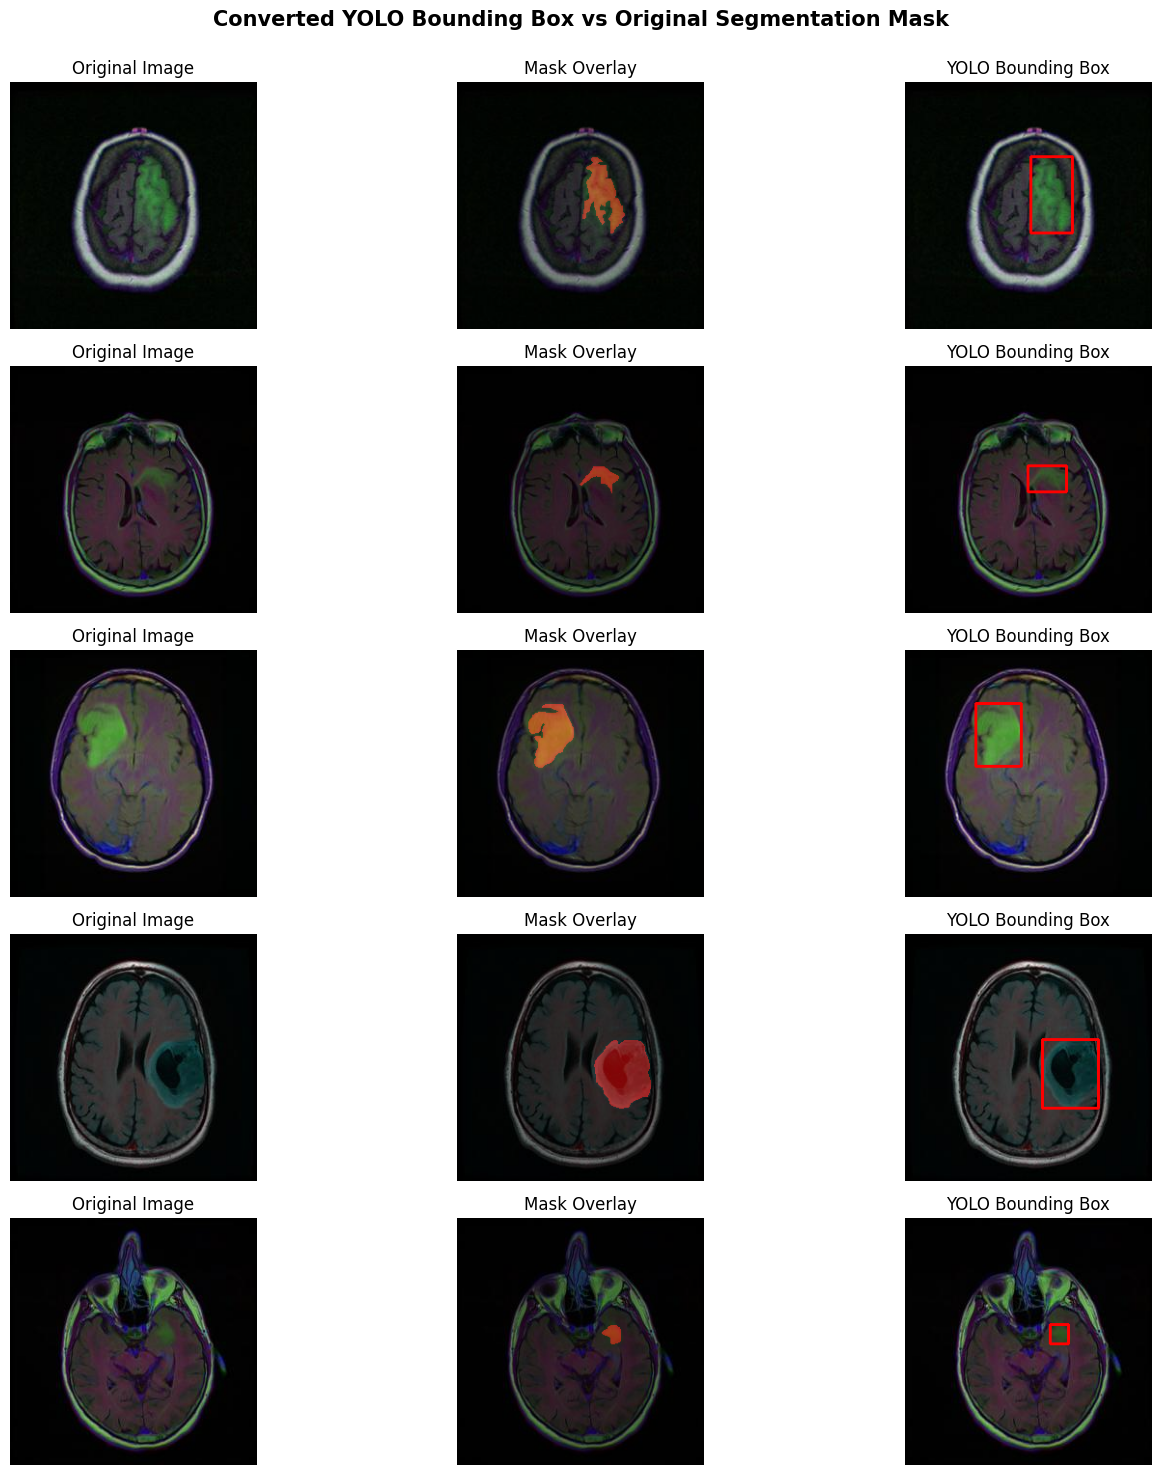

In [48]:
# Temp configuration
image_dir = '/content/dataset_yolo/images/train'
label_dir = '/content/dataset_yolo/labels/train'
mask_root = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

# Get all .jpg files from train folder
all_images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random_images = random.sample(all_images, 5)  # Pick 5 random images

# Set up 5 × 3 subplot grid
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i, image_file in enumerate(random_images):
    base = image_file.replace('.jpg', '')

    # Build Paths
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, f"{base}.txt")
    case_folder = "_".join(base.split("_")[:4])
    mask_path = os.path.join(mask_root, case_folder, f"{base}_mask.tif")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Load and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
    else:
        mask_resized = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    # Original Image
    axs[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original Image")

    # Mask Only
    mask_color = np.zeros_like(image)
    mask_color[mask_resized > 0] = [0, 0, 255]
    image_with_mask = cv2.addWeighted(image, 0.7, mask_color, 0.5, 0)  # Optional: adjust blend

    axs[i, 1].imshow(cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB))
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Mask Overlay")

    # Bounding Box Only
    image_with_bbox = image.copy()
    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            labels = file.readlines()
        for label in labels:
            parts = label.strip().split()
            class_id, cx, cy, w, h = map(float, parts)
            img_h, img_w = image.shape[:2]
            cx, cy, w, h = cx * img_w, cy * img_h, w * img_w, h * img_h
            x1, y1 = int(cx - w / 2), int(cy - h / 2)
            x2, y2 = int(cx + w / 2), int(cy + h / 2)
            cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), (0, 0, 255), 2)

    axs[i, 2].imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    axs[i, 2].axis('off')
    axs[i, 2].set_title("YOLO Bounding Box")

#  Title and Layout
plt.suptitle('Converted YOLO Bounding Box vs Original Segmentation Mask', fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('Converted YOLO BBX vs Original')
plt.show()


# YOLO setup and training

In [19]:
# Creating YAML File with absolute path
data_yaml = {
    'path': str(yolo_dataset.resolve()),  # Resolve to an absolute path
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 1,  # Number of classes
    'names': ['tumor']  # List of class names
}

# Write the YAML data to a file
with open(yolo_dataset / "data.yaml", "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"YAML file created at: {yolo_dataset / 'data.yaml'}")

YAML file created at: dataset_yolo/data.yaml


Training with Early Stopping

In [22]:
!yolo train model=yolo11l.pt data='dataset_yolo/data.yaml' epochs=100 imgsz=640 batch=16 patience=10

100% 49.0M/49.0M [00:00<00:00, 112MB/s]
Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0,

Evaluting on Test Set

In [23]:
!yolo detect val model=runs/detect/train/weights/best.pt data='dataset_yolo/data.yaml' split=test

Ultralytics 8.3.138 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 245.3±85.8 MB/s, size: 6.0 KB)
val: Scanning /content/dataset_yolo/labels/test... 62 images, 0 backgrounds, 0 corrupt: 100% 62/62 [00:00<00:00, 3248.92it/s]
val: New cache created: /content/dataset_yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:02<00:00,  1.38it/s]
                   all         62         62      0.927      0.919      0.951      0.698
Speed: 0.3ms preprocess, 36.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


# Evaluation

### Train and Val Set

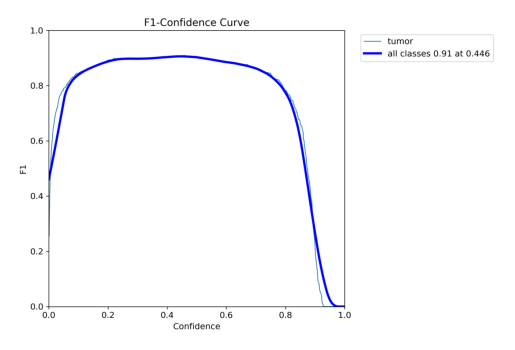

In [50]:
# F1-Confidence Curve
img = Image.open("/content/runs/detect/train/F1_curve.png")
plt.imshow(img)
plt.axis('off')
plt.show()

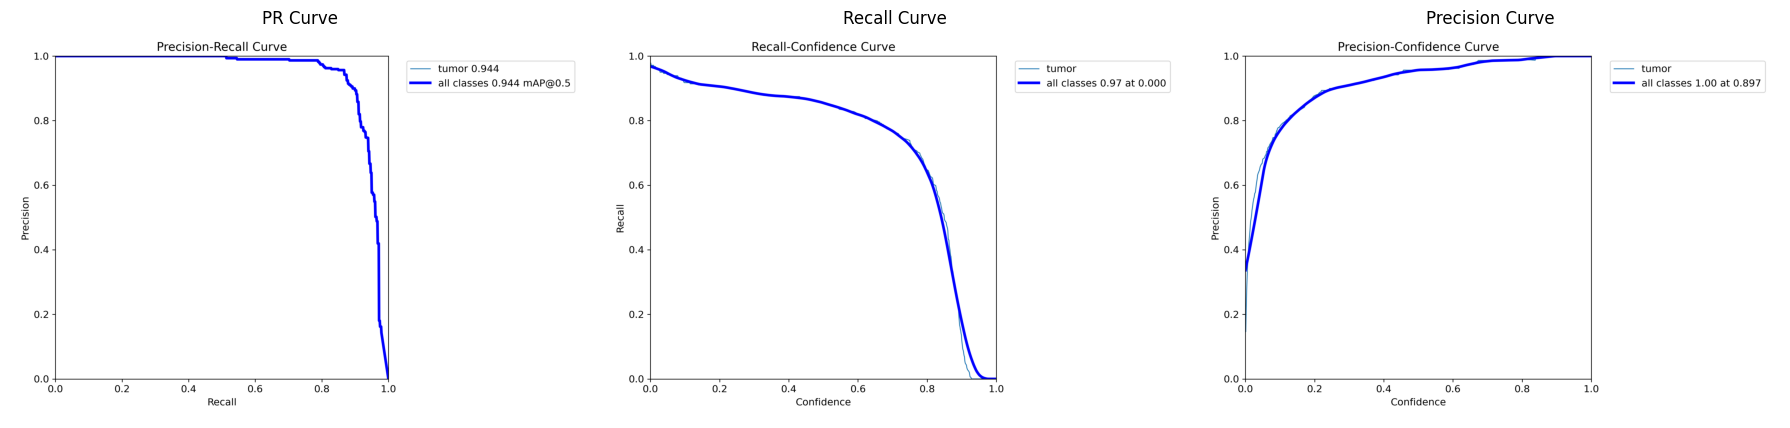

In [51]:
# PR Curve

# Open the images
img_pr_curve = Image.open("/content/runs/detect/train/PR_curve.png")
img_recall_curve = Image.open("/content/runs/detect/train/R_curve.png")
img_precision_curve = Image.open("/content/runs/detect/train/P_curve.png")

# Create a figure with multiple subplots (adjust as needed)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Display the PR curve in the first subplot
axes[0].imshow(img_pr_curve)
axes[0].set_title("PR Curve")
axes[0].axis('off')  # Hide axes for the PR curve image

# Display the recall curve in the second subplot
axes[1].imshow(img_recall_curve)
axes[1].set_title("Recall Curve")
axes[1].axis('off')  # Hide axes for the recall curve image

# Display the precision curve in the third subplot
axes[2].imshow(img_precision_curve)
axes[2].set_title("Precision Curve")
axes[2].axis('off')  # Hide axes for the precision curve image

# Show the plot
plt.tight_layout()
plt.savefig('Training_PR_curve')
plt.show()


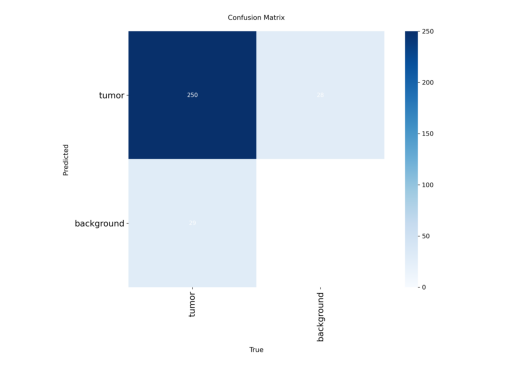

In [27]:
# Confusion Matrix

img = Image.open("/content/runs/detect/train/confusion_matrix.png")
plt.imshow(img)
plt.axis('off')
plt.show()

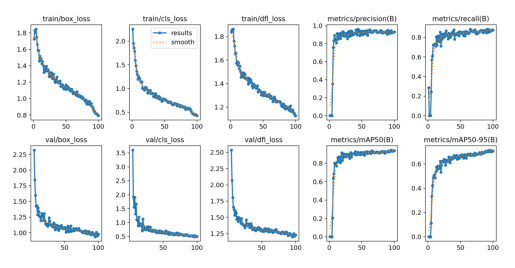

In [29]:
img = Image.open("/content/runs/detect/train/results.png")
plt.imshow(img)
plt.axis('off')
plt.show()

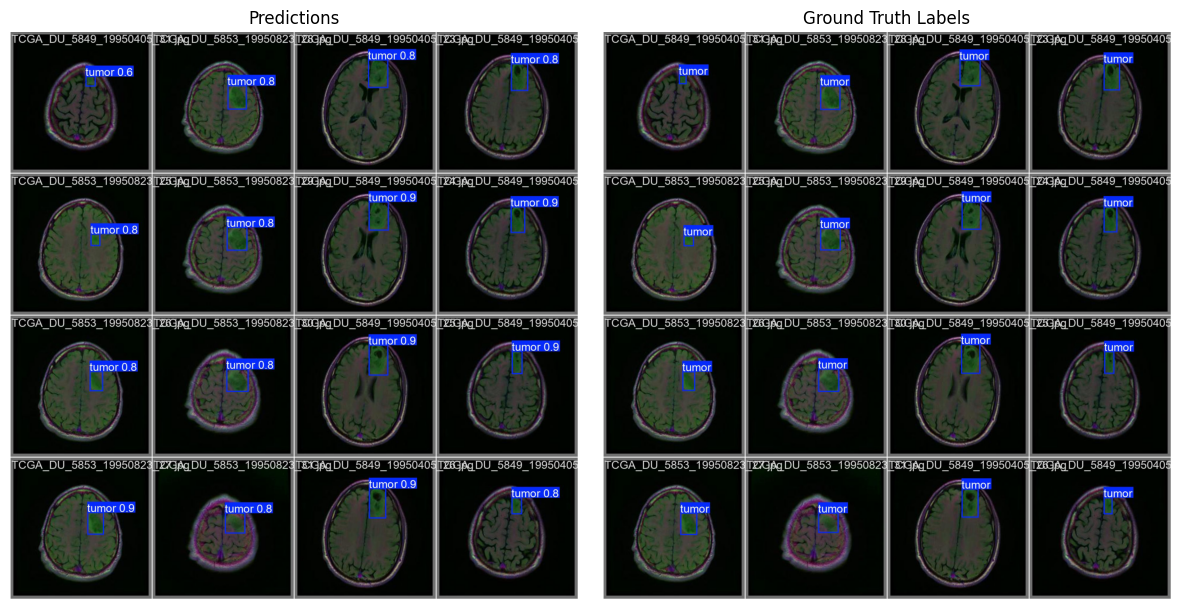

In [32]:
# Train Set Prediction vs Actual
# Open the images
img_pred = Image.open("/content/runs/detect/train/val_batch1_pred.jpg")
img_labels = Image.open("/content/runs/detect/train/val_batch1_labels.jpg")

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display the predicted image
axes[0].imshow(img_pred)
axes[0].set_title("Predictions")
axes[0].axis('off')  # Hide axes for the first image

# Display the ground truth labels image
axes[1].imshow(img_labels)
axes[1].set_title("Ground Truth Labels")
axes[1].axis('off')  # Hide axes for the second image

# Show the plot
plt.tight_layout()
plt.show()


### Test Set

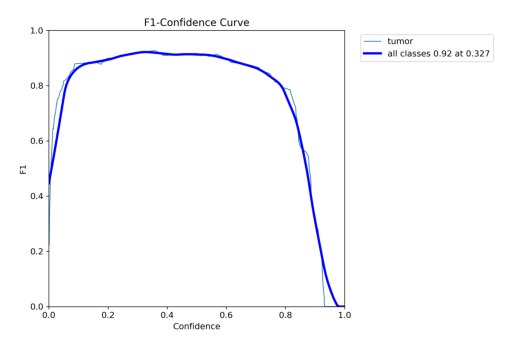

In [33]:
# F1-Curve

img = Image.open("/content/runs/detect/val/F1_curve.png")
plt.imshow(img)
plt.axis('off')
plt.show()

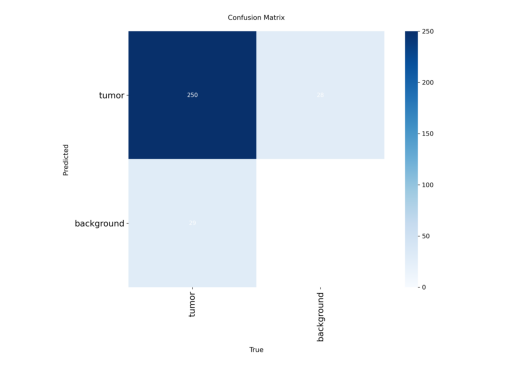

In [41]:
# Confusion Matrix

img = Image.open("/content/runs/detect/train/confusion_matrix.png")
plt.imshow(img)
plt.axis('off')
plt.show()

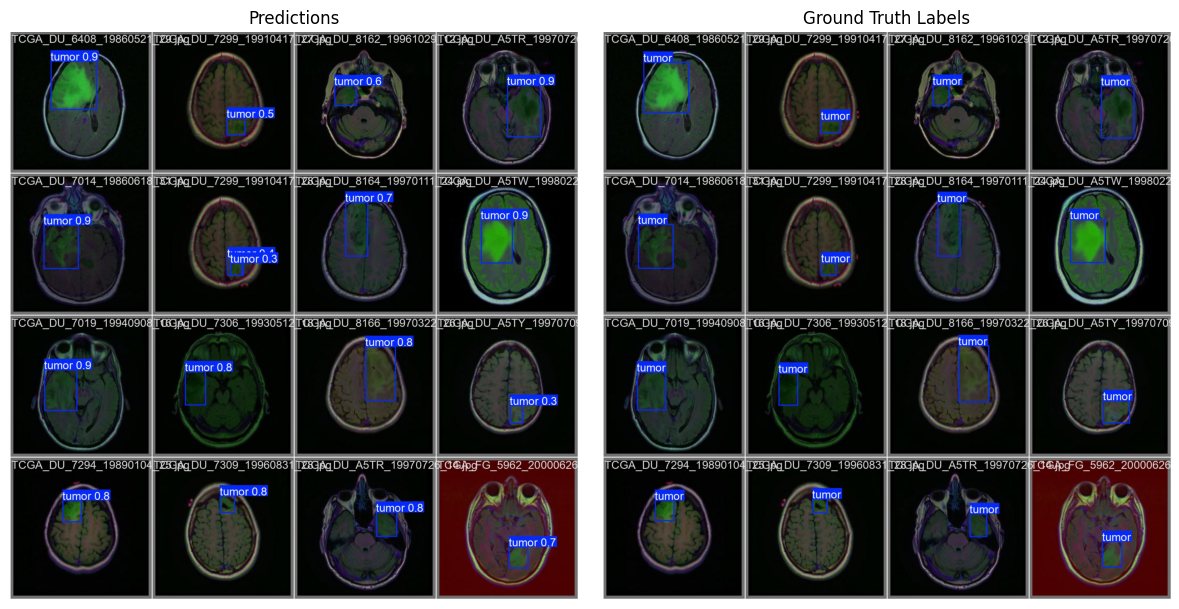

In [52]:
# Test-Set Prediction vs Ground Truth
# Open the images
img_pred = Image.open("/content/runs/detect/val/val_batch1_pred.jpg")
img_labels = Image.open("/content/runs/detect/val/val_batch1_labels.jpg")

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display the predicted image
axes[0].imshow(img_pred)
axes[0].set_title("Predictions")
axes[0].axis('off')  # Hide axes for the first image

# Display the ground truth labels image
axes[1].imshow(img_labels)
axes[1].set_title("Ground Truth Labels")
axes[1].axis('off')  # Hide axes for the second image

# Show the plot
plt.tight_layout()
plt.savefig('Test_Prediction_vs_Ground_Truth')
plt.show()



---

